# Model Tuning
---
In this notebook, we train and tune and baseline model, XGBoost model and Random Forest model.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import dataframe_image as dfi
import joblib

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntUniformDistribution, UniformDistribution, LogUniformDistribution, CategoricalDistribution
from optuna.samplers import TPESampler

### Settings

In [17]:
warnings.simplefilter(action='ignore', category = FutureWarning)

### Import Data

In [18]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part = '03')

In [19]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_val, y_val = f.split_data_X_y(val)
X_test, y_test = f.split_data_X_y(test)

In [20]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
val_data = {'X' : X_val, 'y' : y_val}
test_data = {'X' : X_test, 'y' : y_test}

### Create Baseline Model

In [21]:
# Create and train baseline model
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

lr model... trained


In [22]:
# Save baseline model
joblib.dump(lr, p.OUTPUTS_PATH + 'baseline_model.pkl')

['./outputs/baseline_model.pkl']

### Evaluate Initial Models on Train and Test Data

In [23]:
models = [lr]

# Calculate initial results for train and validation
r2_baseline_results = {
    'Model' : ['Linear Regresssion (Baseline)'],
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'R2 Validation' : [f.evaluate_model(model, metric = 'r2', **val_data) for model in models]
    }

# Display results as a dataframe
baseline_results = pd.DataFrame(r2_baseline_results)
baseline_results[['R2 Train', 'R2 Validation']].T

,0
R2 Train,0.684695
R2 Validation,0.659549


Our baseline seems to perform at a reasonably high level which is a good start. The values are close which suggests the model is robust.

### Initial Models for XGBoost and Random Forest

In [24]:
# Define base parameters for each model
base_params = {
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

In [25]:
# Initiate XGB Model
xgb_optuna_base = XGBRegressor(**base_params)

In [26]:
# Initiate RF Model
rf_optuna_base = RandomForestRegressor(**base_params)

In [27]:
models = [lr, xgb_optuna_base, rf_optuna_base]

# Calculate R2 Score for train and validation datasets for each model
r2_initial_results = {
    'Model' : ['Linear Regresssion (Baseline)', 'Initial XGBoost', 'Initial Random Forest'],
    'R2 Train' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **train_data) for model in models],
    'R2 Validation' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **val_data) for model in models]
    }

# Display results as a dataframe
initial_results = pd.DataFrame(r2_initial_results)
initial_results

,Model,R2 Train,R2 Validation
0,Linear Regresssion (Baseline),0.684695,0.659549
1,Initial XGBoost,0.978792,0.874675
2,Initial Random Forest,0.981705,0.868119


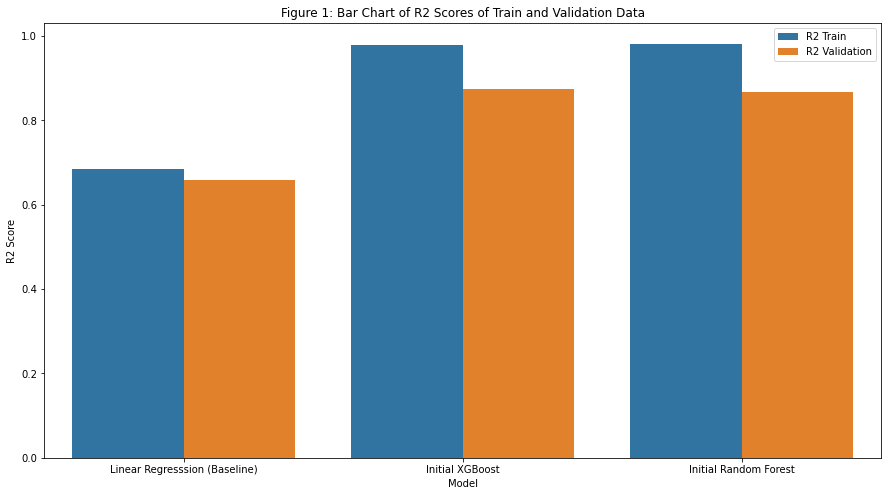

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))

# Change data so it is it displayable format
melt_data = initial_results.melt(id_vars = 'Model')

# Make barplot
sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'Model',
    y = 'value',
    hue = 'variable').set(title = 'Figure 1: Bar Chart of R2 Scores of Train and Validation Data')

# Adjust plot features
plt.ylabel('R2 Score')
plt.legend()

# Save plot
plt.savefig(p.OUTPUTS_PATH + 'initial_models.png')

# Show plot
plt.show()

1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.978792 and 0.874675 from train and validation respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

In [29]:
# Define sampler to be used in optuna search
sampler = TPESampler(seed = p.RANDOM_STATE)

### XGB Tuning

In [30]:
# Define Optuna parameters
xgb_oscv_params = {
    'max_depth' : CategoricalDistribution([2,3,4,5]),
    'learning_rate' : CategoricalDistribution([0.01, 0.03, 0.1, 0.3]),
    'min_child_weight' : IntUniformDistribution(5, 10),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'subsample' : UniformDistribution(0.1, 1),
    'gamma' : LogUniformDistribution(1e-2, 10.0),
    'colsample_bytree' : UniformDistribution(0.1, 1),
    'reg_lambda' : LogUniformDistribution(1e-2, 10.0),
    'reg_alpha' : LogUniformDistribution(1e-2, 10.0)
    }

# Create optuna study
xgb_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'XGB_HyperParam_CV')

# Initiate Optuna Search
xgb_oscv = OptunaSearchCV(
    study = xgb_study,
    estimator = xgb_optuna_base,
    param_distributions = xgb_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1,
)

# Fit search to training set
xgb_oscv.fit(X_train, y_train, verbose = 0)

[I 2022-05-04 18:17:50,347] A new study created in memory with name: XGB_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_58821/4286368788.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_oscv = OptunaSearchCV(
[I 2022-05-04 18:17:50,352] Searching the best hyperparameters using 5256 samples...
[I 2022-05-04 18:18:19,908] Trial 4 finished with value: 0.8324038308072138 and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'min_child_weight': 7, 'n_estimators': 103, 'subsample': 0.2658207756245732, 'gamma': 2.8601461412265836, 'colsample_bytree': 0.9525074867034767, 'reg_lambda': 2.028417647785666, 'reg_alpha': 1.9003613706517777}. Best is trial 4 with value: 0.8324038308072138.
[I 2022-05-04 18:18:32,360] Trial 6 finished with value: 0.726482938562997 and parameters: {'max_depth': 2, 'learning_rate': 0.03, 'min_child_weight': 8, 'n_estimators': 298, 'subsample': 0.7862568052713937

OptunaSearchCV(cv=10,
               estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1,
                                      enable_categorical=False, gamma=0,
                                      gpu_id=-1, importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.300000012,
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints='()',
                                      n_estimators=...
                                    'min_child_weight': IntUniformDistribution(high=10, low=5, step=1),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1),
                           

### Generate Tuning Visualisations

In [31]:
# Display optuna visualisation for xgb study
f.make_optuna_visualizations(xgb_study)

### Extract Best Performing Estimator

In [32]:
# Take best estimator from the optuna search
xgb_tuned = xgb_oscv.best_estimator_

In [33]:
# Evaluate xgb model
train_r2 = f.evaluate_model(xgb_tuned, metric = 'r2', **train_data)
val_r2 = f.evaluate_model(xgb_tuned, metric = 'r2', **val_data)

# Print performance metrics
print('Train R2:', train_r2)
print('Validation R2:', val_r2)

Train R2: 0.985247
Validation R2: 0.878169


The metrics show the model is a little overfit so we will do some manual adjustments.

### Manual Hyperparameter Adjustments

##### subsample

In [58]:
oscv_params = xgb_oscv.best_params_

# Create record dictionary
results_record = {
    'subsample' : [],
    'Train R2 Score' : [],
    'Validation R2 Score' : []}

# Loop through hyperparameter options
for ss in np.arange(0.45, 0.85, 0.05):

    model_params = {
        **base_params,
        **oscv_params,
        'subsample' : ss
        }

    # Create model with parameters
    fn_model = XGBRegressor(**model_params).fit(**train_data)

    # Evaluate model
    train_r2 = f.evaluate_model(fn_model, metric = 'r2', **train_data)
    val_r2 = f.evaluate_model(fn_model, metric = 'r2', **val_data)

    # Save metrics to record dictionary
    results_record['subsample'].append(ss)
    results_record['Train R2 Score'].append(train_r2)
    results_record['Validation R2 Score'].append(val_r2)

# Make Results a dataframe
pd_results_record = pd.DataFrame(results_record)

# Calculate difference in R2 Scores
pd_results_record['Difference'] = pd_results_record['Train R2 Score'] - pd_results_record['Validation R2 Score']

pd_results_record_out = pd_results_record.nsmallest(8, 'Difference').set_index('subsample')

pd_results_record_out

,Train R2 Score,Validation R2 Score,Difference
subsample,,,
0.60,0.984580,0.879588,0.104992
0.80,0.986143,0.880749,0.105394
0.65,0.985050,0.879540,0.105510
0.50,0.982182,0.876306,0.105876
0.70,0.985483,0.879463,0.106020
0.45,0.980634,0.874369,0.106265
0.75,0.986250,0.879381,0.106869
0.55,0.983150,0.876185,0.106965


There does not seem to be much of a change here so we will move to another set of hyperparameters.

##### `max_depth` and `learning_rate`

In [50]:
oscv_params = xgb_oscv.best_params_

# Set parameters to test
max_depth_params  = [2,3,4,5,6]
learning_rate_params = [0.01, 0.03, 0.1]

# Find all permutations of parameters
param_perms = product(max_depth_params, learning_rate_params)

# Define record dictionary
results_record = {
    'max_depth' : [],
    'learning_rate' : [],
    'Train R2 Score' : [],
    'Validation R2 Score' : []}

# Loop through possible reults
for md, learnr in param_perms:

    model_params = {
        **base_params,
        **oscv_params,
        'max_depth' : md,
        'learning_rate' : learnr
        }


    # Train model
    fn_model = XGBRegressor(**model_params).fit(**train_data)

    # Evaluate model
    train_r2 = f.evaluate_model(fn_model, metric = 'r2', **train_data)
    val_r2 = f.evaluate_model(fn_model, metric = 'r2', **val_data)

    # Save metrics
    results_record['max_depth'].append(md)
    results_record['learning_rate'].append(learnr)
    results_record['Train R2 Score'].append(train_r2)
    results_record['Validation R2 Score'].append(val_r2)

pd_results_record = pd.DataFrame(results_record)

pd_results_record['Difference'] = pd_results_record['Train R2 Score'] - pd_results_record['Validation R2 Score']

pd_results_record_out = pd_results_record.nsmallest(8, 'Difference').set_index(['max_depth', 'learning_rate'])

pd_results_record_out

Train R2 Score  Validation R2 Score  Difference
max_depth learning_rate                                                 
2         0.03                 0.831287             0.809192    0.022095
          0.01                 0.736916             0.714724    0.022192
3         0.01                 0.813143             0.786560    0.026583
4         0.01                 0.859726             0.826695    0.033031
3         0.03                 0.886174             0.846713    0.039461
5         0.01                 0.889622             0.848550    0.041072
2         0.10                 0.885431             0.843926    0.041505
6         0.01                 0.911562             0.861799    0.049763

In [43]:
# Export dataframe as image
dfi.export(pd_results_record_out, p.OUTPUTS_PATH + 'tweaking_df.png')

objc[65631]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa62d1a318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/101.0.4951.54/Libraries/libGLESv2.dylib (0x10e829218). One of the two will be used. Which one is undefined.
[0505/175841.628972:INFO:headless_shell.cc(660)] Written to file /var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/tmpti5xmk2m/temp.png.


These results seem more promising. Due to the small gap and high values, we choose `max_depth` = 3 and `learning_rate` = 0.03

### Train final XGBoost Model

In [51]:
xgb_final_params = {**base_params, **oscv_params}

# Set manual adjustments
xgb_final_params['max_depth'] = 3
xgb_final_params['learning_rate'] = 0.03

# Train final XGB model
final_xgb_tuned = XGBRegressor(**xgb_final_params).fit(**train_data)

In [52]:
# Evaluate final model
train_r2 = f.evaluate_model(final_xgb_tuned, metric = 'r2', **train_data)
val_r2 = f.evaluate_model(final_xgb_tuned, metric = 'r2', **val_data)

# Print metrics
print('Train R2:', train_r2)
print('Test R2:', val_r2)

Train R2: 0.886174
Test R2: 0.846713


In [55]:
# Save XGB model
joblib.dump(final_xgb_tuned, p.OUTPUTS_PATH + 'xgb_model.pkl')

['./outputs/xgb_model.pkl']

### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [34]:
model = rf_optuna_base.fit(**train_data)

# Evaluate model
train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
val_r2 = f.evaluate_model(model, metric = 'r2', **val_data)

# Print results
print('Train R2:', train_r2)
print('Test R2:', val_r2)

Train R2: 0.981705
Test R2: 0.868119


### Optuna Search

In [35]:
# Define optuna parameters
rf_oscv_params = {
    'max_depth' : IntUniformDistribution(6, 15),
    'max_features' : CategoricalDistribution(['auto', 'sqrt', 'log2']),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'bootstrap' : CategoricalDistribution([True, False]),
    'min_samples_leaf' : UniformDistribution(0, 0.5),
    'min_samples_split' : UniformDistribution(0, 0.5),
    }

# Create optuna study
rf_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'RF_HyperParam_CV')

# Initiate optuna search
rf_oscv = OptunaSearchCV(
    study = rf_study,
    estimator = rf_optuna_base,
    param_distributions = rf_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1
)

# Fit optuna search to training data
rf_oscv.fit(X_train, y_train)

[I 2022-05-04 22:27:34,325] A new study created in memory with name: RF_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_58821/548707989.py:12: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-05-04 22:27:34,329] Searching the best hyperparameters using 5256 samples...
[I 2022-05-04 22:27:57,581] Trial 4 finished with value: 0.24239856233205948 and parameters: {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 73, 'bootstrap': True, 'min_samples_leaf': 0.29865857160004006, 'min_samples_split': 0.387935949304937}. Best is trial 4 with value: 0.24239856233205948.
[I 2022-05-04 22:28:57,095] Trial 3 finished with value: 0.2384037390712665 and parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 129, 'bootstrap': False, 'min_samples_leaf': 0.48761740104823403, 'min_samples_split': 0.17321585685906338}. Best is trial 4 with value: 0.24239856233205948.
[I 2022-05-04 2

OptunaSearchCV(cv=10,
               estimator=RandomForestRegressor(n_jobs=-1, random_state=73),
               n_jobs=-1, n_trials=200,
               param_distributions={'bootstrap': CategoricalDistribution(choices=(True, False)),
                                    'max_depth': IntUniformDistribution(high=15, low=6, step=1),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')),
                                    'min_samples_leaf': UniformDistribution(high=0.5, low=0.0),
                                    'min_samples_split': UniformDistribution(high=0.5, low=0.0),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)},
               random_state=73, scoring='r2',
               study=<optuna.study.study.Study object at 0x176129df0>,
               verbose=1)

### Generate Tuning Visualisations

In [36]:
# Display optuna visualisations for RF study
f.make_optuna_visualizations(rf_study)

### Extract Best Estimator

In [37]:
# Get best estimator from optuna search
rf_tuned = rf_oscv.best_estimator_

In [38]:
# Print evaluation metrics
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **val_data))

Train R2: 0.862037
Test R2: 0.790892


These values look much better, but it would be good to explore if we can reduce the overfitting with some manual adjustments. Since `min_samples_leaf` is the most influencial feature, we shall explore adjusting this.

In [66]:
oscv_params = rf_oscv.best_params_

# Define record dictionary
results_record = {
    'min_samples_leaf' : [],
    'Train R2 Score' : [],
    'Validation R2 Score' : []}

# Loop through possible hyperparameters
for msl in np.arange(0.00001, 0.001, 0.00001):

    model_params = {
        **base_params,
        **oscv_params,
        'min_samples_leaf' : msl
        }

    # Train model
    fn_model = RandomForestRegressor(**model_params).fit(**train_data)

    # Evaluate model
    train_r2 = f.evaluate_model(fn_model, metric = 'r2', **train_data)
    val_r2 = f.evaluate_model(fn_model, metric = 'r2', **val_data)

    # Save metrics to record
    results_record['min_samples_leaf'].append(msl)
    results_record['Train R2 Score'].append(train_r2)
    results_record['Validation R2 Score'].append(val_r2)

pd_results_record = pd.DataFrame(results_record)

pd_results_record['Difference'] = pd_results_record['Train R2 Score'] - pd_results_record['Validation R2 Score']

pd_results_record_out = pd_results_record.nsmallest(8, 'Difference').set_index('min_samples_leaf')

pd_results_record_out

,Train R2 Score,Validation R2 Score,Difference
min_samples_leaf,,,
0.00077,0.865041,0.798588,0.066453
0.00078,0.865041,0.798588,0.066453
0.00079,0.865041,0.798588,0.066453
0.00080,0.865041,0.798588,0.066453
0.00081,0.865041,0.798588,0.066453
0.00082,0.865041,0.798588,0.066453
0.00083,0.865041,0.798588,0.066453
0.00084,0.865041,0.798588,0.066453


There does not seem to be much of an effect so we will keep the hyperparameters that optuna found.

In [54]:
# Save RF Model
joblib.dump(rf_tuned, p.OUTPUTS_PATH + 'rf_model.pkl')

['./outputs/rf_model.pkl']